# Customers' Age Determination

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

The customer set a task to develop a neural network capable of determining the age of customers of the "Bread&Salt" retail chain based on their photos. The ultimate goal of implementing this algorithm is to create recommendation systems for customers of different age groups and monitor alcohol sales.

A regression problem is set, with the target feature presented as an integer. Mean absolute error is used as the metric of the project. The client's requirement is for MAE to be less than 8 (years of error between the real age and the prediction). The formula for calculating MAE is as follows:

$$MAE = \frac{\sum_{i=1}^{n}\left | y_{i} - x_{i} \right |}{n}$$

The used dataset is accessible online: [link](https://chalearnlap.cvc.uab.cat/dataset/26/description/). For neural network training purposes, a cloud service with high computing resources was used. During the EDA, train, valid and test folders were merged to assess the full amount of data available.

## Exploratory Data Analysis

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=16,
        class_mode='raw',
        seed=1) 

Found 7591 validated image filenames.


There are ~7.6 thousand photos available in the dataset. This amount may be insufficient to train neural networks with ResNet architecture. We will use data augmentation to generate more data for training purposes.

We will build an age distribution histogram in the dataset and use the .describe() method to research the distribution.

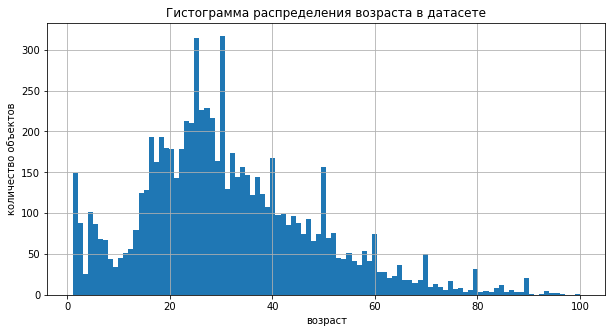

In [24]:
plt.subplots(figsize=(10, 5))
labels['real_age'].hist(bins = 100)
plt.xlabel('age')
plt.ylabel('number of objects')
plt.title('Age distribution histogram in the dataset')
plt.show()

In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

The dataset contains photographs of people aged from 1 to 100. The majority of photos are labeled as photos of people aged from 20 to 30 (constituting approximately 25% of the dataset). The average age of individuals in the photos is 31 years.

There is a peak in values around 1 year. Around the age of 10, the number of images decreases, gradually increasing afterward. This pattern is probably related to the project goals: developing recommendation systems and checking the legality of alcohol sales may not be relevant for this age group.

Let's display a sample of 15 random photos from the dataset on the screen.

(16, 256, 256, 3)
4


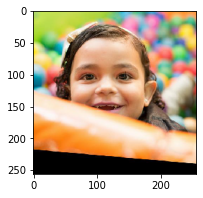

(16, 256, 256, 3)
18


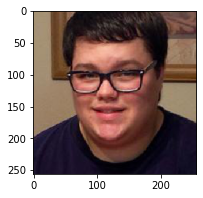

(16, 256, 256, 3)
15


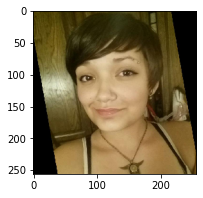

(16, 256, 256, 3)
21


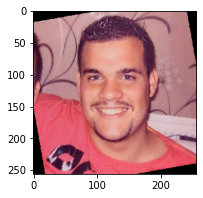

(16, 256, 256, 3)
8


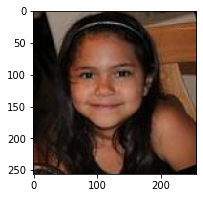

(16, 256, 256, 3)
19


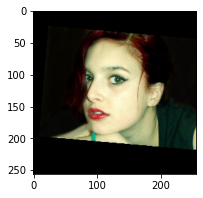

(16, 256, 256, 3)
21


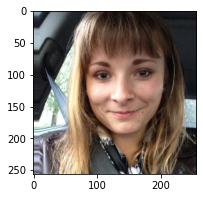

(16, 256, 256, 3)
28


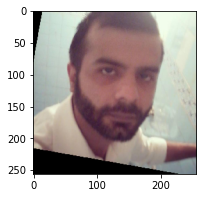

(16, 256, 256, 3)
40


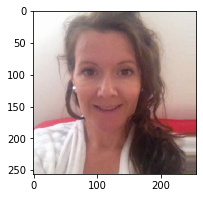

(16, 256, 256, 3)
33


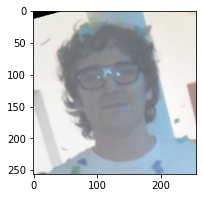

(16, 256, 256, 3)
28


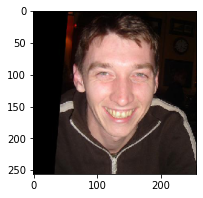

(16, 256, 256, 3)
48


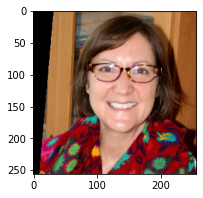

(16, 256, 256, 3)
37


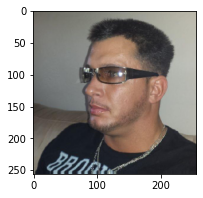

(16, 256, 256, 3)
43


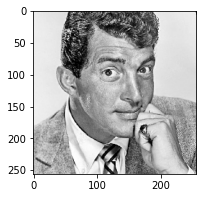

(16, 256, 256, 3)
32


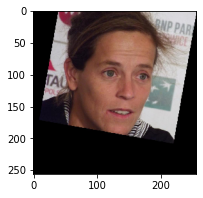

In [23]:
for i in range(15):
    plt.subplots(figsize=(3, 3))
    img, label = gen_flow.next()
    print(img.shape)
    print(label[0])
    plt.imshow(img[0])
    plt.show()

The photos depict people's faces from various angles, wearing different clothes and accessories. Based on the sample, it seems that the photos are not vertically flipped, so applying the vertical_flip parameter during augmentation in the training set is unnecessary for effective training.

Most of the photos are colored, there is no need to convert them to grayscale. Some photos are rotated at an angle of <25 degrees, resulting in black borders. To account for this dataset feature, we will add the parameter *rotation_range = 15* during the augmentation. We will also use *horizontal_flip = True* parameter.

Based on this sample, it appears that the labeling of the target feature has been done correctly.

## Deep Learning

```python
import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    files = path + 'final_files/'
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, rotation_range = 15, horizontal_flip = True)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe = labels,
        directory = files,
        target_size = (224, 224),
        batch_size = 16,
        x_col = 'file_name',
        y_col = 'real_age',
        class_mode = 'raw',
        subset = 'training',
        seed=1)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    files = path + 'final_files/'
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe = labels,
        directory = files,
        target_size = (224, 224),
        batch_size = 16,
        x_col = 'file_name',
        y_col = 'real_age',
        class_mode = 'raw',
        subset = 'validation',
        seed=1)
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr = 0.0001)
    backbone = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(10, activation='relu')) 
    model.add(Dense(1, activation='linear')) 
    model.compile(optimizer=optimizer, loss='mean_squared_error', 
              metrics=['mae']) 
    return model

def train_model(model, train_data, test_data, batch_size = None, epochs = 20,
               steps_per_epoch = None, validation_steps = None):
    model.fit(train_data, 
              validation_data = test_data,
              batch_size = batch_size, epochs = epochs,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps,
              verbose = 2, shuffle = True)
    return model 

```

```
Train for 356 steps, validate for 119 steps
Epoch 1/20
356/356 - 114s - loss: 245.6237 - mae: 11.4029 - val_loss: 694.7304 - val_mae: 21.4280
Epoch 2/20
356/356 - 107s - loss: 98.7201 - mae: 7.5715 - val_loss: 139.8772 - val_mae: 8.7911
Epoch 3/20
356/356 - 107s - loss: 78.4592 - mae: 6.7004 - val_loss: 154.8320 - val_mae: 9.6385
Epoch 4/20
356/356 - 107s - loss: 65.5510 - mae: 6.1821 - val_loss: 131.9015 - val_mae: 7.9476
Epoch 5/20
Epoch 6/20
356/356 - 107s - loss: 52.4173 - mae: 5.5684 - val_loss: 72.8609 - val_mae: 6.4137
356/356 - 107s - loss: 44.5200 - mae: 5.1431 - val_loss: 98.1741 - val_mae: 7.3072
Epoch 7/20
356/356 - 107s - loss: 38.5096 - mae: 4.7767 - val_loss: 74.0509 - val_mae: 6.3165
Epoch 8/20
356/356 - 107s - loss: 33.4384 - mae: 4.4207 - val_loss: 82.8504 - val_mae: 6.8840
Epoch 9/20
356/356 - 107s - loss: 28.1745 - mae: 4.0999 - val_loss: 73.3974 - val_mae: 6.3389
Epoch 10/20
356/356 - 107s - loss: 24.5820 - mae: 3.7975 - val_loss: 74.9429 - val_mae: 6.7249
Epoch 11/20
356/356 - 107s - loss: 22.2196 - mae: 3.6308 - val_loss: 75.5155 - val_mae: 6.8108
Epoch 12/20
356/356 - 107s - loss: 19.1182 - mae: 3.3653 - val_loss: 77.0950 - val_mae: 6.5156
Epoch 13/20
356/356 - 107s - loss: 17.8432 - mae: 3.2744 - val_loss: 74.5343 - val_mae: 6.2984
Epoch 14/20
Epoch 15/20
356/356 - 107s - loss: 17.2227 - mae: 3.1753 - val_loss: 76.1068 - val_mae: 6.4034
356/356 - 107s - loss: 19.7219 - mae: 3.3603 - val_loss: 86.8811 - val_mae: 7.0718
Epoch 16/20
356/356 - 107s - loss: 19.0237 - mae: 3.3515 - val_loss: 70.7357 - val_mae: 6.3579
Epoch 17/20
Epoch 18/20
356/356 - 107s - loss: 15.3532 - mae: 3.0105 - val_loss: 65.8785 - val_mae: 5.9536
Epoch 19/20
356/356 - 107s - loss: 13.7410 - mae: 2.8647 - val_loss: 65.8805 - val_mae: 5.9596
Epoch 20/20
356/356 - 107s - loss: 12.2630 - mae: 2.6892 - val_loss: 64.4513 - val_mae: 6.1098
356/356 - 107s - loss: 12.2888 - mae: 2.6996 - val_loss: 64.9278 - val_mae: 5.8025

```

The best MAE on the test sample we achieved in 20 epochs is equal to 5.8025.

## Conclusion

The task set by the customer has been successfully completed - the mean absolute error (absolute difference between real values and neural network predictions) is less than 8 years. During the project, functions *load_train*, *load_test*, *create_model*, and *train_model* were developed and tested.

During the loading of the training set, data augmentation was applied to generate new images for training purposes, with specified parameters: rotation within 15 degrees and horizontal reflection. These parameters were implemented to account for characteristics of the original dataset and protect the model from overfitting.

**Model Architecture:** The neural network consists of a sequential model with a pre-trained ResNet50, the application of GlobalAveragePooling2D, a fully connected layer with 10 neurons and a ReLU activation, and a fully connected layer with 1 neuron and linear activation at the output. This model architecture allows effective interpretation of results during the implementation in business, which is crucial for the project's objectives.

The Adam optimizer was used with a learning rate set to 0.0001. The model reaches the target metric value of 5.8025 after 20 epochs. However, for business use, it is recommended to use the proposed network with only 5 epochs - its MAE is ~6.4, but the time required for training of the network is about 3 times less. The difference in metric will not affect the practical effectiveness of the model but will reduce computational resources needed tremendously.

**Reference page**

Agustsson, Eirikur & Timofte, Radu & Escalera, Sergio & Baró, Xavier & Guyon, Isabelle & Rothe, Rasmus. (2017). Apparent and Real Age Estimation in Still Images with Deep Residual Regressors on Appa-Real Database. 10.1109/FG.2017.20. 